In [1]:
import dask.dataframe as dd
import  pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import time
import gc 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import os
import torch 
from matplotlib import pyplot as plt

In [2]:
# start_time = time.time()
# train= pd.read_csv('/home/carlchao/Riiid/data/train.csv',
#                 usecols=[1, 2, 3,4,7,8,9], dtype={'timestamp': 'int64', 'user_id': 'int32' ,'content_id': 'int16','content_type_id': 'int8','answered_correctly':'int8','prior_question_elapsed_time': 'float32','prior_question_had_explanation': 'int8'})
# # train= pd.read_csv('/home/carlchao/Riiid/data/train.csv')
# print("pandas took %s seconds" % (time.time() - start_time))
# # train = train[train.content_type_id == False]

In [3]:
# !pip install datatable
import datatable as dt
start_time = time.time()
train = dt.fread('/home/carlchao/Riiid_data/data/train.csv')
train = train.to_pandas()
print("datatable took %s seconds" % (time.time() - start_time))



datatable took 14.413197040557861 seconds


In [4]:
train = train.sort_values(['timestamp'], ascending=True)

train.drop(['timestamp','content_type_id'], axis=1,   inplace=True)

results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
results_u.columns = ["answered_correctly_user", 'sum']

In [5]:
#reading in question df
questions_df = pd.read_csv('/home/carlchao/Riiid_data/data/questions.csv',
                            usecols=[0,1, 3,4],
                            dtype={'question_id': 'int16',
                              'part': 'int8','bundle_id': 'int8','tags': 'str'}
                          )
tag = questions_df["tags"].str.split(" ", n = 10, expand = True) 
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

questions_df =  pd.concat([questions_df,tag],axis=1)
questions_df['tags1'] = pd.to_numeric(questions_df['tags1'], errors='coerce')
questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce')
questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce')
questions_df['tags4'] = pd.to_numeric(questions_df['tags4'], errors='coerce')
questions_df['tags5'] = pd.to_numeric(questions_df['tags5'], errors='coerce')
questions_df['tags6'] = pd.to_numeric(questions_df['tags6'], errors='coerce')

In [11]:
X = train.iloc[80000000:,:].copy()
X['prior_question_had_explanation'].fillna(False, inplace=True)
X = pd.merge(X, results_u, on=['user_id'], how="left")
X = pd.merge(X, results_c, on=['content_id'], how="left")
X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

X=X[X.answered_correctly!= -1 ]
X=X.sort_values(['user_id'])
Y = X[["answered_correctly"]]
X = X.drop(["answered_correctly"], axis=1)

In [43]:
X.shape

(20830198, 10)

In [12]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])
X.head()

X = X[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc','tags1','tags2','tags3']] 
X.fillna(0.5,  inplace=True)


nunique = X.nunique()
categorical_columns = []
categorical_dims =  {}

for col in ['part','tags1','tags2','tags3']:
    if  nunique[col] < 200:
        print(col, X[col].nunique())
        l_enc = LabelEncoder()
        X[col] = X[col].fillna("VV_likely")
        X[col] = l_enc.fit_transform(X[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        X.fillna(X[col].mean(), inplace=True)
        
from  sklearn.tree import DecisionTreeClassifier
from  sklearn.model_selection import train_test_split
Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size =0.2, shuffle=False)

# import lightgbm as lgb


# params = {
#     'objective': 'binary',
#     'max_bin': 600,
#     'learning_rate': 0.02,
#     'num_leaves': 80
# }


# lgb_train = lgb.Dataset(Xt, Yt,categorical_feature = ['part','tags1','tags2','tags3'])
# lgb_eval = lgb.Dataset(Xv, Yv, reference=lgb_train,categorical_feature = ['part','tags1','tags2','tags3'])

# model = lgb.train(
#     params, lgb_train,
#     valid_sets=[lgb_train, lgb_eval],
#     verbose_eval=10,
#     num_boost_round=10000,
#     early_stopping_rounds=10,
#     categorical_feature = ['part','tags1','tags2','tags3']
# )


part 7
tags1 117
tags2 87
tags3 54


In [18]:
categorical_columns = ['part','tags1','tags2','tags3']
features = X.columns
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

In [19]:

    
max_epochs = 20 if not os.getenv("CI", False) else 2
batch_size = 1024
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                       scheduler_params={"is_batch_level":True,
                                         "max_lr":5e-2,
                                         "steps_per_epoch":int(train.shape[0] / batch_size)+1,
                                         "epochs":max_epochs
                                          },
                       mask_type='entmax', # "sparsemax",
                       verbose =1,
                      )

Device used : cuda


In [20]:
start_time = time.time()
clf.fit(
    X_train=Xt.values, y_train=Yt.values.squeeze(),
    eval_set=[(Xt.values, Yt.values.squeeze()), (Xv.values, Yv.values.squeeze())],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    loss_fn=torch.nn.functional.cross_entropy, # Optional, just an example of list usage,
    
)
print("training took %s seconds" % (time.time() - start_time))

epoch 0  | loss: 0.5421  | train_auc: 0.74968 | valid_auc: 0.75093 |  0:13:15s
epoch 1  | loss: 0.53851 | train_auc: 0.75028 | valid_auc: 0.75138 |  0:27:03s
epoch 2  | loss: 0.53798 | train_auc: 0.75062 | valid_auc: 0.75176 |  0:41:07s
epoch 3  | loss: 0.53779 | train_auc: 0.75078 | valid_auc: 0.7519  |  0:55:04s
epoch 4  | loss: 0.5377  | train_auc: 0.75058 | valid_auc: 0.75167 |  1:09:08s
epoch 5  | loss: 0.53777 | train_auc: 0.75068 | valid_auc: 0.75183 |  1:23:05s
epoch 6  | loss: 0.53776 | train_auc: 0.75068 | valid_auc: 0.75176 |  1:37:09s
epoch 7  | loss: 0.53783 | train_auc: 0.75041 | valid_auc: 0.75156 |  1:51:23s
epoch 8  | loss: 0.53793 | train_auc: 0.75074 | valid_auc: 0.75179 |  2:05:26s
epoch 9  | loss: 0.53799 | train_auc: 0.75019 | valid_auc: 0.75133 |  2:19:20s
epoch 10 | loss: 0.53808 | train_auc: 0.75068 | valid_auc: 0.75182 |  2:33:13s
epoch 11 | loss: 0.53796 | train_auc: 0.75061 | valid_auc: 0.75171 |  2:47:18s
epoch 12 | loss: 0.53784 | train_auc: 0.75108 | vali

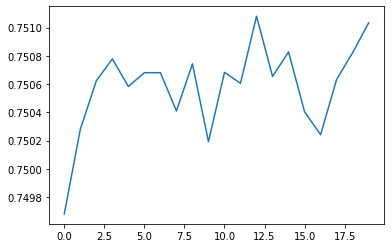

In [30]:
# plot auc
plt.plot(clf.history['train_auc'])


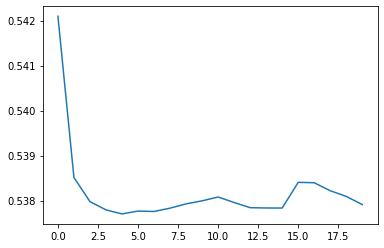

In [31]:
plt.plot(clf.history['loss'])

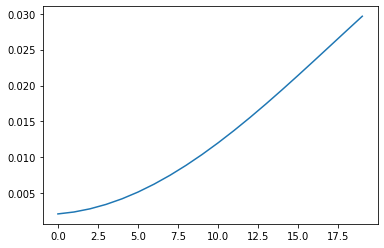

In [33]:
plt.plot(clf.history['lr'])

In [34]:
# y_pred = clf.predict(Xv)
# y_true = np.array(Yv)
# roc_auc_score(y_true, y_pred)
preds_valid = clf.predict_proba(Xv.values)


NameError: name 'y_valid' is not defined

In [40]:
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=Yv.values.squeeze())
# valid_auc = roc_auc_score(y_score=preds_valid, y_true=Yv.values.squeeze())

In [41]:
valid_auc

0.7521353178130463

In [37]:
explain_matrix, masks = clf.explain(Xv.values)

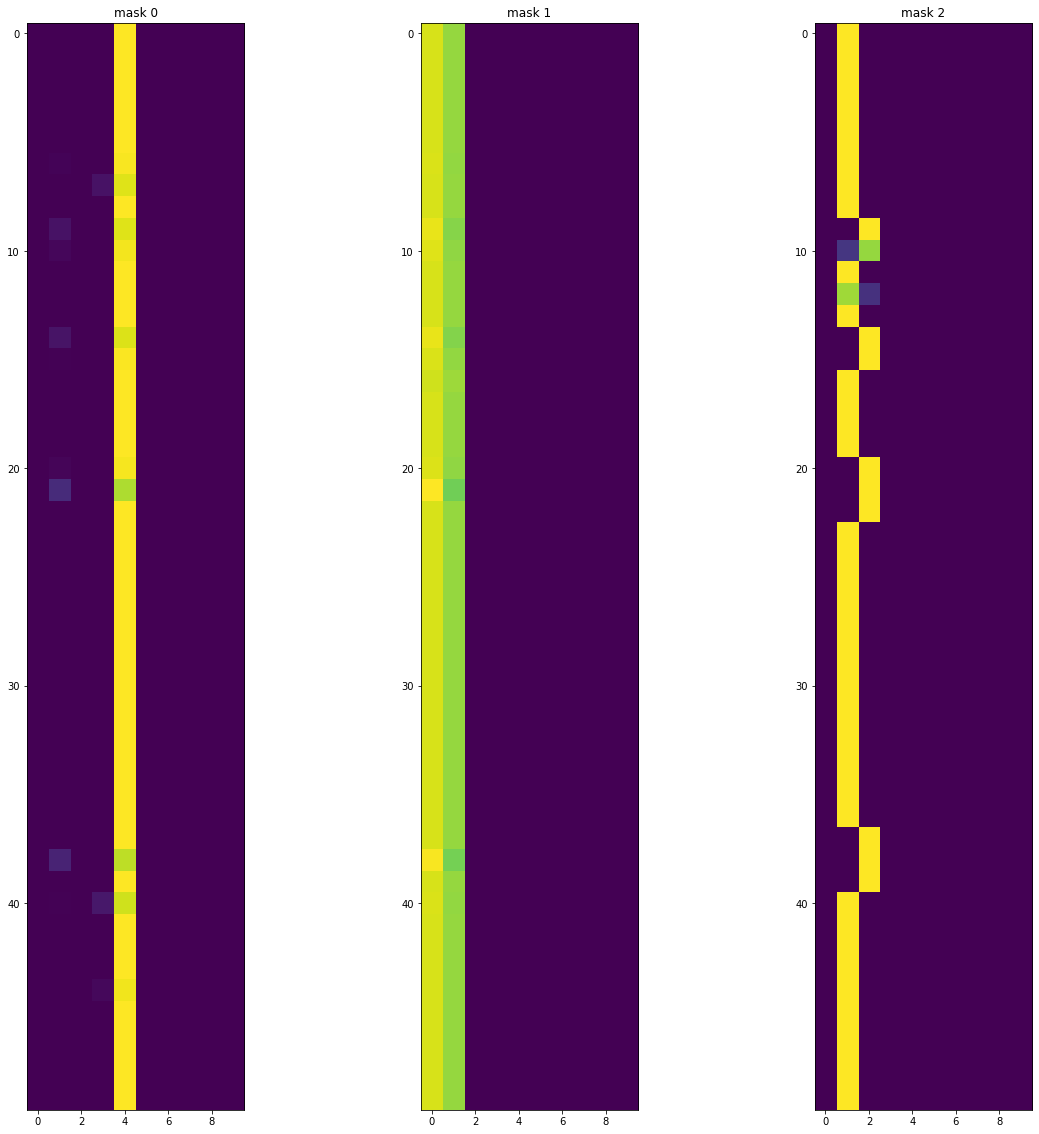

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [ ]:
# iter_test = env.iter_test()
# for (test_df, sample_prediction_df) in iter_test:
#     test_df = test_df.sort_values(['user_id','timestamp'], ascending=False)
#     test_df['answer_time'] = test_df.groupby(['user_id'])['prior_question_elapsed_time'].shift(1)
    
#     test_df = pd.merge(test_df, results_u, on=['user_id'],  how="left")
#     test_df = pd.merge(test_df, results_c, on=['content_id'],  how="left")    
#     test_df = pd.merge(test_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')    
#     test_df['answered_correctly_user'].fillna(0.5, inplace=True)
#     test_df['answered_correctly_content'].fillna(0.5, inplace=True)
#     test_df['sum'].fillna(0, inplace=True)
#     test_df['prior_question_had_explanation'].fillna(False, inplace=True)
#     test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
#     test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc',
#                                                            'tags1','tags2','tags3']])
#     env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])